### Image generation with trained Diffusion Model
Example of how to load a model and generate an image with it.

In [7]:
# Ensure notebook sees necessary paths
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [13]:
## Imports
from Architectures.DifussionModel import generate
from Trainers.DiffusionTrainer import TrainingConfig
from diffusers import DDPMPipeline
import torch
import glob
from PIL import Image

import os
from torchvision.utils import make_grid, save_image
from torchvision.transforms import ToPILImage

In [18]:
# loading the config
config = TrainingConfig().from_json("../configs/config3.json")
config.output_dir = "../Saved_Models/Unet_Logger_config_3/"

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = DDPMPipeline.from_pretrained(
    config.output_dir,
    torch_dtype=torch.float16,
    use_safetensors=True    
)
pipeline.to(device)

Loading pipeline components...: 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "../Saved_Models/Unet_Logger_config_3/",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [20]:
# Generation!
generate(config, pipeline)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:23<00:00,  6.97it/s]

Saved 16 images + grid at: ../Saved_Models/Unet_Logger_config_3/generated


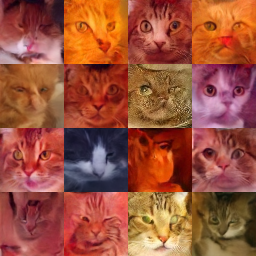

In [21]:
sample_images = sorted(glob.glob(f"{config.output_dir}/generated/grid.png"))
Image.open(sample_images[-1])

In [36]:
import os
import torch
from torchvision.utils import make_grid, save_image
from torchvision import transforms

def interpolate_latents(
    config,
    pipeline,
    seed1: int = 42,
    seed2: int = 1234,
    num_interps: int = 8
):
    device = pipeline.device
    unet = pipeline.unet
    scheduler = pipeline.scheduler
    scheduler.set_timesteps(scheduler.num_train_timesteps, device=device)

    H = config.image_size
    C = unet.config.in_channels
    dtype = next(unet.parameters()).dtype

    g1 = torch.Generator(device).manual_seed(seed1)
    z1 = torch.randn((1, C, H, H), generator=g1, device=device, dtype=dtype)
    g2 = torch.Generator(device).manual_seed(seed2)
    z2 = torch.randn((1, C, H, H), generator=g2, device=device, dtype=dtype)

    total = num_interps + 2
    alphas = torch.linspace(0, 1, steps=total, device=device, dtype=dtype)

    latents = (1 - alphas)[:, None, None, None] * z1 + alphas[:, None, None, None] * z2

    @torch.no_grad()
    def decode(z: torch.Tensor) -> torch.Tensor:
        x = z.clone()
        for t in reversed(scheduler.timesteps):
            ts = torch.full((x.size(0),), t, device=device, dtype=torch.long)
            pred = unet(x, ts)["sample"]
            x = scheduler.step(pred, t, x)["prev_sample"]
        return x.clamp(0, 1)

    decoded = [decode(lat.unsqueeze(0) if lat.ndim==3 else lat) for lat in latents]

    out = os.path.join(config.output_dir, "latent_interp")
    os.makedirs(out, exist_ok=True)
    to_tensor = transforms.ToTensor()

    for i, img_t in enumerate(decoded):
        save_image(img_t.squeeze(0), os.path.join(out, f"img_{i:02d}.png"))
    grid = make_grid(torch.stack([img.squeeze(0) for img in decoded]), nrow=total)
    save_image(grid, os.path.join(out, "grid.png"))

    print(f"Saved {total} interpolated images + grid at {out}")


In [37]:
interpolate_latents(config, pipeline)

d:\Pulpit\DeepLearning\DeepLearning\Project_III\venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Saved 10 interpolated images + grid at ../Saved_Models/Unet_Logger_config_3/latent_interp
